# Cyberattack Classification Using Deep Learning

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization, Conv1D, Bidirectional
from tensorflow.keras.models import load_model
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import warnings
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, SpatialDropout1D, Add,
    GRU, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense,
    Dropout, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Table of Contents

1. **Introduction**  
2. **Dataset Description**  
3. **Problem Statement**  
4. **Data Preprocessing**  
   - Handling Outliers  
   - Encoding Categorical Features  
   - Standardization  
   - Feature Selection  
5. **Model Architecture**  
6. **Training and Evaluation**  
7. **Results**  
8. **Conclusions**  
9. **References**


## 1. Introduction

Cybersecurity is a critical area in today's connected world. Identifying and classifying cyberattacks using deep learning can provide a robust solution to mitigate threats efficiently. This project focuses on using the **UNSW-NB15** dataset to build a deep learning model for multi-class classification of cyberattacks.

---

## 2. Dataset Description

The UNSW-NB15 dataset contains a diverse range of network attack data. It includes normal and nine types of attack categories:
- Fuzzers
- Analysis
- Backdoors
- DoS
- Exploits
- Generic
- Reconnaissance
- Shellcode
- Worms

Each instance includes 49 features and labels for attack categories.
- - -

In [14]:
class NetworkTrafficPipeline:
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.path = None
        
    def download_dataset(self):
        """Download dataset using kagglehub."""
        self.path = kagglehub.dataset_download("dhoogla/unswnb15")
        print("Dataset downloaded to:", self.path)
        return self.path
    
    def load_data(self):
        """Load training and testing datasets."""
        train_data = pd.read_parquet(f"{self.path}/UNSW_NB15_training-set.parquet")
        test_data = pd.read_parquet(f"{self.path}/UNSW_NB15_testing-set.parquet")
        return train_data, test_data

In [15]:
# Initialize pipeline
pipeline = NetworkTrafficPipeline()
    
# Download and load data
path = pipeline.download_dataset()
train_data, test_data = pipeline.load_data()

Dataset downloaded to: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


# 3. Problem Statement 

This project focuses on network intrusion detection using deep learning techniques. Our main objectives are:

- Develop a robust multi-class classification model for network traffic
- Address the class imbalance challenge in cybersecurity datasets
- Create an effective preprocessing pipeline for network traffic data
- Implement and evaluate a deep learning solution for real-time threat detection
- - -



# 4 Data Analysis

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import List, Dict, Optional, Tuple, Union
from sklearn.metrics import confusion_matrix, classification_report
import warnings

class UNSWDataAnalyzer:
    def __init__(self, data: pd.DataFrame):
        """
        Initialize the analyzer with a DataFrame
        
        Parameters:
        -----------
        data : pd.DataFrame
            The UNSW-NB15 dataset (can be either pre or post processed)
        """
        self.data = data.copy()
        self.categorical_cols = ['proto', 'service', 'state']
        self.target_cols = ['attack_cat', 'label']
        plt.style.use('fivethirtyeight')
        warnings.filterwarnings('ignore')
    
    def basic_info(self) -> Dict:
        """
        Get basic information about the dataset
        """
        info = {
            'total_records': len(self.data),
            'missing_values': self.data.isnull().sum().to_dict(),
            'memory_usage': self.data.memory_usage(deep=True).sum() / 1024**2,  # in MB
            'duplicate_rows': self.data.duplicated().sum()
        }
        
        if 'label' in self.data.columns:
            info['attack_distribution'] = self.data['label'].value_counts().to_dict()
            
        if 'attack_cat' in self.data.columns:
            info['attack_categories'] = self.data['attack_cat'].value_counts().to_dict()
            
        return info
    
    def analyze_attack_patterns(self) -> Dict[str, pd.DataFrame]:
        """
        Analyze patterns in different types of attacks
        """
        patterns = {}
        
        if 'attack_cat' in self.data.columns:
            # Analyze protocol distribution per attack
            patterns['protocol_distribution'] = pd.crosstab(
                self.data['attack_cat'], 
                self.data['proto'], 
                normalize='index'
            )
            
            # Analyze service distribution per attack
            patterns['service_distribution'] = pd.crosstab(
                self.data['attack_cat'], 
                self.data['service'], 
                normalize='index'
            )
            
            # Calculate average metrics per attack type
            numeric_cols = self.data.select_dtypes(include=[np.number]).columns
            patterns['attack_metrics'] = self.data.groupby('attack_cat')[numeric_cols].mean()
            
        return patterns
    
    def temporal_analysis(self, time_window: str = '1H') -> Optional[pd.DataFrame]:
        """
        Analyze attack patterns over time
        
        Parameters:
        -----------
        time_window : str
            Time window for aggregation (default: '1H' for 1 hour)
        """
        if 'Stime' in self.data.columns:
            self.data['Stime'] = pd.to_datetime(self.data['Stime'])
            temporal_patterns = self.data.set_index('Stime').resample(time_window).agg({
                'label': 'sum',
                'attack_cat': lambda x: x.value_counts().to_dict() if 'attack_cat' in self.data else None,
                'proto': 'count'
            })
            return temporal_patterns
        return None
    
    def feature_importance_analysis(self, target: str = 'label') -> pd.DataFrame:
        """
        Analyze feature importance using correlation and statistical tests
        """
        if target not in self.data.columns:
            raise ValueError(f"Target column '{target}' not found in dataset")
            
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        importance_metrics = pd.DataFrame()
        
        # Correlation analysis
        correlations = self.data[numeric_cols].corrwith(self.data[target])
        importance_metrics['correlation'] = correlations.abs()
        
        # Chi-square test for categorical features
        for cat_col in self.categorical_cols:
            if cat_col in self.data.columns:
                chi2, p_value = stats.chi2_contingency(
                    pd.crosstab(self.data[cat_col], self.data[target])
                )[:2]
                importance_metrics.loc[cat_col, 'chi2_statistic'] = chi2
                importance_metrics.loc[cat_col, 'p_value'] = p_value
        
        return importance_metrics.sort_values('correlation', ascending=False)
    
    def plot_attack_distribution(self, figsize: Tuple[int, int] = (12, 6)):
        """
        Plot the distribution of attacks in the dataset
        """
        plt.figure(figsize=figsize)
        
        if 'attack_cat' in self.data.columns:
            attack_counts = self.data['attack_cat'].value_counts()
            sns.barplot(x=attack_counts.index, y=attack_counts.values)
            plt.xticks(rotation=45)
            plt.title('Distribution of Attack Categories')
            plt.xlabel('Attack Type')
            plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    
    def plot_feature_distributions(self, columns: Optional[List[str]] = None, 
                                 figsize: Tuple[int, int] = (15, 10)):
        """
        Plot distributions of specified features
        """
        if columns is None:
            numeric_cols = self.data.select_dtypes(include=[np.number]).columns
            columns = numeric_cols[:min(len(numeric_cols), 9)]
        
        n_cols = 3
        n_rows = (len(columns) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()
        
        for idx, col in enumerate(columns):
            if col in self.data.columns:
                sns.histplot(data=self.data, x=col, hue='label' if 'label' in self.data.columns else None,
                           ax=axes[idx], bins=30)
                axes[idx].set_title(f'Distribution of {col}')
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model_performance(self, y_true: np.ndarray, y_pred: np.ndarray, 
                                 class_names: Optional[List[str]] = None) -> Dict:
        """
        Evaluate model performance after preprocessing and training
        
        Parameters:
        -----------
        y_true : np.ndarray
            True labels
        y_pred : np.ndarray
            Predicted labels
        class_names : List[str], optional
            Names of the classes
        """
        results = {}
        
        # Classification report
        results['classification_report'] = classification_report(
            y_true, y_pred, target_names=class_names, output_dict=True
        )
        
        # Confusion matrix
        results['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(results['confusion_matrix'], 
                   annot=True, 
                   fmt='d',
                   xticklabels=class_names if class_names else 'auto',
                   yticklabels=class_names if class_names else 'auto')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        return results
    
    def analyze_feature_correlations(self, threshold: float = 0.8) -> pd.DataFrame:
        """
        Analyze and identify highly correlated features
        
        Parameters:
        -----------
        threshold : float
            Correlation threshold to identify strong correlations
        """
        numeric_data = self.data.select_dtypes(include=[np.number])
        corr_matrix = numeric_data.corr()
        
        # Get upper triangle of correlations
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find features with correlation greater than threshold
        high_corr = [(i, j, corr_matrix.loc[i,j]) 
                    for i in corr_matrix.index 
                    for j in corr_matrix.columns 
                    if i < j and abs(corr_matrix.loc[i,j]) > threshold]
        
        return pd.DataFrame(high_corr, columns=['Feature 1', 'Feature 2', 'Correlation'])
    
    def detect_anomalies(self, columns: List[str], method: str = 'zscore', 
                        threshold: float = 3.0) -> pd.DataFrame:
        """
        Detect anomalies in specified columns
        
        Parameters:
        -----------
        columns : List[str]
            Columns to check for anomalies
        method : str
            Method to use for anomaly detection ('zscore' or 'iqr')
        threshold : float
            Threshold for z-score method
        """
        anomalies = pd.DataFrame()
        
        for col in columns:
            if col not in self.data.columns:
                continue
                
            if method == 'zscore':
                z_scores = np.abs(stats.zscore(self.data[col]))
                anomalies[col] = z_scores > threshold
            elif method == 'iqr':
                Q1 = self.data[col].quantile(0.25)
                Q3 = self.data[col].quantile(0.75)
                IQR = Q3 - Q1
                anomalies[col] = ((self.data[col] < (Q1 - 1.5 * IQR)) | 
                                (self.data[col] > (Q3 + 1.5 * IQR)))
        
        return anomalies
    
    def get_attack_profiles(self) -> pd.DataFrame:
        """
        Generate profiles for different types of attacks based on their characteristics
        """
        if 'attack_cat' not in self.data.columns:
            return pd.DataFrame()
        
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns
        profiles = self.data.groupby('attack_cat')[numeric_cols].agg([
            'mean', 'std', 'min', 'max'
        ])
        
        # Add categorical features distribution
        for cat_col in self.categorical_cols:
            if cat_col in self.data.columns:
                cat_dist = self.data.groupby('attack_cat')[cat_col].agg(
                    lambda x: x.value_counts().index[0]
                )
                profiles[f'{cat_col}_most_common'] = cat_dist
        
        return profiles

In [17]:
data = pd.concat([train_data, test_data], axis=0)
# Initialize with your data
analyzer = UNSWDataAnalyzer(data)

# Get basic information about the dataset
info = analyzer.basic_info()
print(info)

{'total_records': 257673, 'missing_values': {'dur': 0, 'proto': 0, 'service': 0, 'state': 0, 'spkts': 0, 'dpkts': 0, 'sbytes': 0, 'dbytes': 0, 'rate': 0, 'sload': 0, 'dload': 0, 'sloss': 0, 'dloss': 0, 'sinpkt': 0, 'dinpkt': 0, 'sjit': 0, 'djit': 0, 'swin': 0, 'stcpb': 0, 'dtcpb': 0, 'dwin': 0, 'tcprtt': 0, 'synack': 0, 'ackdat': 0, 'smean': 0, 'dmean': 0, 'trans_depth': 0, 'response_body_len': 0, 'ct_src_dport_ltm': 0, 'ct_dst_sport_ltm': 0, 'is_ftp_login': 0, 'ct_ftp_cmd': 0, 'ct_flw_http_mthd': 0, 'is_sm_ips_ports': 0, 'attack_cat': 0, 'label': 0}, 'memory_usage': 51.90054130554199, 'duplicate_rows': 112451, 'attack_distribution': {1: 164673, 0: 93000}, 'attack_categories': {'Normal': 93000, 'Generic': 58871, 'Exploits': 44525, 'Fuzzers': 24246, 'DoS': 16353, 'Reconnaissance': 13987, 'Analysis': 2677, 'Backdoor': 2329, 'Shellcode': 1511, 'Worms': 174}}


In [18]:
# Analyze attack patterns
patterns = analyzer.analyze_attack_patterns()
print(patterns)

{'protocol_distribution': proto                3pc       a/n  aes-sp3-d       any     argus      aris  \
attack_cat                                                                    
Analysis        0.002988  0.002988   0.002988  0.008965  0.002988  0.002988   
Backdoor        0.003006  0.003006   0.003006  0.009017  0.003006  0.003006   
DoS             0.002691  0.002691   0.002691  0.008072  0.002691  0.002691   
Exploits        0.001235  0.001235   0.001235  0.003706  0.001235  0.001235   
Fuzzers         0.000412  0.000412   0.000412  0.001237  0.000412  0.000412   
Generic         0.000017  0.000017   0.000017  0.000051  0.000000  0.000017   
Normal          0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
Reconnaissance  0.000500  0.000500   0.000500  0.001501  0.000500  0.000500   
Shellcode       0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   
Worms           0.000000  0.000000   0.000000  0.000000  0.000000  0.000000   

proto                arp 

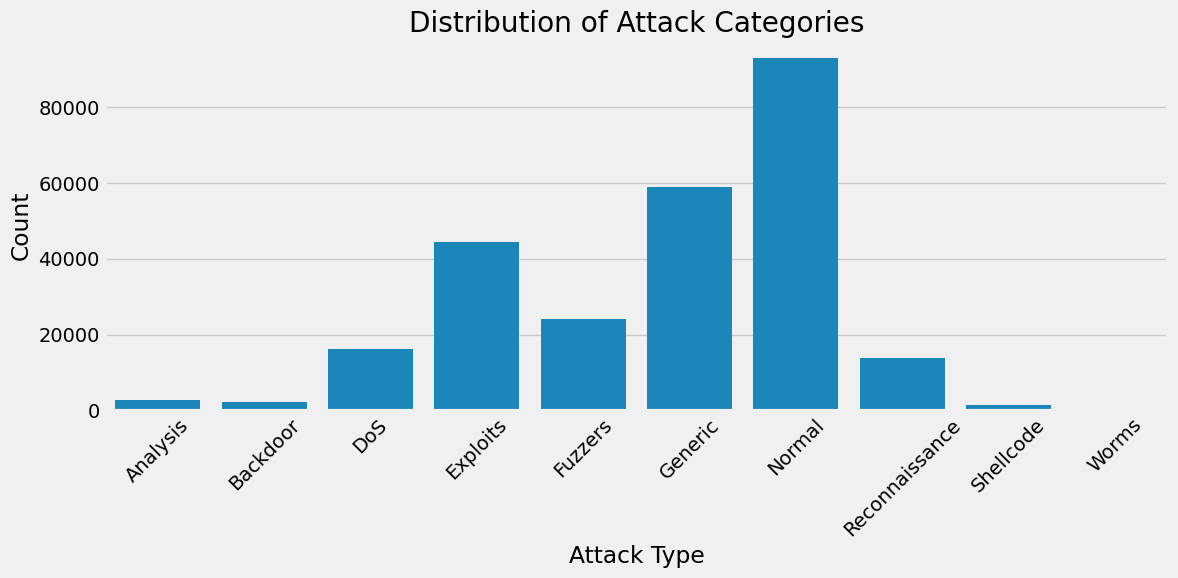

In [19]:
# Plot attack distribution
analyzer.plot_attack_distribution()

In [20]:
# Analyze feature importance
feature_importance = analyzer.feature_importance_analysis()
print(feature_importance)

                   correlation  chi2_statistic  p_value
label                 1.000000             NaN      NaN
ct_dst_sport_ltm      0.371672             NaN      NaN
swin                  0.364877             NaN      NaN
dload                 0.352169             NaN      NaN
dwin                  0.339166             NaN      NaN
rate                  0.335883             NaN      NaN
ct_src_dport_ltm      0.318518             NaN      NaN
dmean                 0.295173             NaN      NaN
stcpb                 0.266585             NaN      NaN
dtcpb                 0.263543             NaN      NaN
sload                 0.165249             NaN      NaN
is_sm_ips_ports       0.160126             NaN      NaN
sinpkt                0.155454             NaN      NaN
dpkts                 0.097394             NaN      NaN
dloss                 0.075961             NaN      NaN
dbytes                0.060403             NaN      NaN
djit                  0.048819             NaN  

In [21]:
# Analyze correlations
correlations = analyzer.analyze_feature_correlations(threshold=0.8)
print(correlations)

           Feature 1         Feature 2  Correlation
0             sbytes             spkts     0.964393
1             sbytes             sloss     0.995772
2             dbytes             dpkts     0.973445
3             dbytes             dloss     0.996711
4              sloss             spkts     0.971859
5              dloss             dpkts     0.979612
6               dwin              swin     0.980458
7             synack            tcprtt     0.943053
8             ackdat            tcprtt     0.920218
9   ct_dst_sport_ltm  ct_src_dport_ltm     0.908337
10        ct_ftp_cmd      is_ftp_login     0.998855
11   is_sm_ips_ports            sinpkt     0.942121


In [22]:
# Generate attack profiles
profiles = analyzer.get_attack_profiles()
print(profiles)

                     dur                                      spkts  \
                    mean        std       min        max       mean   
attack_cat                                                            
Analysis        1.416942   7.220232  0.000000  59.932392   5.354875   
Backdoor        2.224558   9.618294  0.000000  59.879597   6.767282   
DoS             2.448795  10.103664  0.000000  59.998409  24.117348   
Exploits        2.122902   7.404824  0.000000  59.999527  33.962021   
Fuzzers         2.673938   9.441919  0.000000  59.996017  13.764827   
Generic         0.061157   1.275712  0.000000  59.972233   2.576770   
Normal          1.015407   4.559376  0.000000  59.999989  27.563172   
Reconnaissance  1.005046   4.929644  0.000000  59.996758   7.034604   
Shellcode       0.362856   0.832788  0.000001  13.154288   5.964924   
Worms           1.333305   2.146530  0.000002  15.887326  18.218391   

                                           dpkts              ...  \
       

# Preprocessing


In [23]:
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTENC

class UNSWPreprocessor:
    def __init__(self, data: pd.DataFrame, test_data: pd.DataFrame, val_size: float = 0.2):
        self.data = data.copy()
        self.test_data = test_data.copy()
        self.val_size = val_size
        self.scalers = {
            'robust': RobustScaler(),
            'standard': StandardScaler()
        }
        self.label_encoder: Dict[str, LabelEncoder] = {}
        self.categorical_columns = ['proto', 'service', 'state']
        self.selected_features = None
        self.feature_selector = None
        self.merge_threshold = 0.05
        self.merged_classes_mapping = None
        self.bounds = {}
        
        # Correlation analysis thresholds
        self.high_corr_threshold = 0.9
        self.correlation_pairs = [
            ('sbytes', 'spkts'), ('sbytes', 'sloss'), 
            ('dbytes', 'dpkts'), ('dbytes', 'dloss'),
            ('dwin', 'swin'), ('synack', 'tcprtt'),
            ('ct_dst_sport_ltm', 'ct_src_dport_ltm')
        ]
        
        # Important features based on correlation with target
        self.important_features = [
            'dload', 'ct_dst_sport_ltm', 'dmean', 'rate',
            'ct_src_dport_ltm', 'is_sm_ips_ports'
        ]

    def handle_unknown_labels(self, data: pd.DataFrame, col: str) -> np.ndarray:
        """
        Handles unknown labels by assigning them a default value (-1)
        """
        encoded_column = []
        for value in data[col]:
            if value in self.label_encoder[col].classes_:
                encoded_column.append(self.label_encoder[col].transform([value])[0])
            else:
                encoded_column.append(-1)
        return np.array(encoded_column)

    def split_train_val(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        return train_test_split(
            X, y,
            test_size=self.val_size,
            stratify=y,
            random_state=42
        )

    def add_engineered_features(self, data: pd.DataFrame) -> pd.DataFrame:
        eps = 1e-8
        
        # Basic rate and ratio features
        data['bytes_per_packet'] = (data['sbytes'] + data['dbytes']) / (data['spkts'] + data['dpkts'] + eps)
        data['bytes_ratio'] = np.log1p(data['sbytes']) - np.log1p(data['dbytes'])
        data['packets_ratio'] = np.log1p(data['spkts']) - np.log1p(data['dpkts'])
        data['packet_rate'] = (data['spkts'] + data['dpkts']) / (data['dur'] + eps)
        data['byte_rate'] = (data['sbytes'] + data['dbytes']) / (data['dur'] + eps)
        
        # Source and destination specific features
        data['srate'] = data['spkts'] / (data['dur'] + eps)
        data['drate'] = data['dpkts'] / (data['dur'] + eps)
        data['sload'] = (data['sbytes'] * data['srate']) / (eps + data['dur'])
        data['dload'] = (data['dbytes'] * data['drate']) / (eps + data['dur'])
        
        # Loss-based features
        data['total_loss_ratio'] = (data['sloss'] + data['dloss']) / (data['spkts'] + data['dpkts'] + eps)
        data['loss_ratio_diff'] = (data['sloss'] / (data['spkts'] + eps)) - (data['dloss'] / (data['dpkts'] + eps))
        
        # Connection-based features
        if 'ct_state_ttl' in data.columns:
            data['conn_ratio'] = data['ct_src_dport_ltm'] / (data['ct_dst_sport_ltm'] + eps)
            data['state_ratio'] = data['ct_state_ttl'] / (data['ct_dst_ltm'] + eps)
            data['ct_dst_src_ratio'] = data['ct_dst_ltm'] / (data['ct_src_dport_ltm'] + eps)
        
        # Statistical features
        data['mean_diff'] = data['smean'] - data['dmean']
        data['jitter_ratio'] = np.log1p(data['sjit']) - np.log1p(data['djit'])
        
        # Complexity features
        if 'swin' in data.columns and 'dwin' in data.columns:
            data['protocol_complexity'] = data['swin'] * data['dwin']
        if 'tcprtt' in data.columns and 'synack' in data.columns:
            data['tcp_behaviour'] = (data['tcprtt'] * data['synack']) / (data['dur'] + eps)
        
        return data

    def handle_outliers(self, data: pd.DataFrame, columns: List[str], is_test: bool = False) -> pd.DataFrame:
        data_clean = data.copy()
        iqr_factor = 2.0 if is_test else 1.5
        
        for column in columns:
            Q1 = self.bounds[column]['Q1']
            Q3 = self.bounds[column]['Q3']
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_factor * IQR
            upper_bound = Q3 + iqr_factor * IQR
            
            if is_test:
                lower_bound = min(lower_bound, data_clean[column].min())
                upper_bound = max(upper_bound, data_clean[column].max())
            
            data_clean[column] = data_clean[column].clip(lower_bound, upper_bound)
            
        return data_clean

    def create_class_mapping(self, y: pd.Series) -> Dict[str, str]:
        class_counts = y.value_counts(normalize=True)
        classes_to_merge = class_counts[class_counts < self.merge_threshold].index
        return {cls: 'other_attack' for cls in classes_to_merge}

    def merge_minority_classes(self, y: pd.Series) -> pd.Series:
        if self.merged_classes_mapping is None:
            self.merged_classes_mapping = self.create_class_mapping(y)
        return y.replace(self.merged_classes_mapping)

    def balance_classes(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Balance classes using a combination of undersampling and oversampling.
        Automatically switches between SMOTE and SMOTENC based on feature types.
        """
        # First use Tomek Links to remove majority class noise
        tl = TomekLinks(sampling_strategy='majority')
        X_cleaned, y_cleaned = tl.fit_resample(X, y)
        
        # Check if we have any categorical features left after feature selection
        categorical_features = [X.columns.get_loc(col) for col in self.categorical_columns 
                              if col in X.columns]
        
        if categorical_features:
            # Use SMOTENC if we have categorical features
            smote = SMOTENC(
                categorical_features=categorical_features, 
                sampling_strategy='auto',
                random_state=42
            )
        else:
            # Use regular SMOTE if we only have numerical features
            smote = SMOTE(
                sampling_strategy='auto',
                random_state=42
            )
            
        return smote.fit_resample(X_cleaned, y_cleaned)

    def select_features(self, X: pd.DataFrame, y: pd.Series, n_features: int = None) -> pd.DataFrame:
        """
        Select features while ensuring categorical features are preserved if needed.
        """
        if self.feature_selector is None:
            # Ensure we keep at least one categorical feature for SMOTENC
            categorical_cols_to_keep = [col for col in self.categorical_columns if col in X.columns]
            
            # Dynamic feature selection based on data dimensionality
            if n_features is None:
                n_features = min(int(np.sqrt(len(X.columns)) * 2), len(X.columns))
                # Ensure we have space for categorical features
                n_features = max(n_features, len(categorical_cols_to_keep))
            
            # Remove highly correlated features
            features_to_drop = []
            corr_matrix = X.corr().abs()
            
            for pair in self.correlation_pairs:
                if pair[0] in X.columns and pair[1] in X.columns:
                    if corr_matrix.loc[pair[0], pair[1]] > self.high_corr_threshold:
                        # Don't drop if it's a categorical feature we want to keep
                        if pair[0] not in categorical_cols_to_keep and pair[0] not in self.important_features:
                            features_to_drop.append(pair[0])
                        elif pair[1] not in categorical_cols_to_keep:
                            features_to_drop.append(pair[1])
            
            X = X.drop(columns=features_to_drop)
            
            # Sample for large datasets
            if len(X) > 50000:
                X_sample = X.sample(n=50000, random_state=42)
                y_sample = y[X_sample.index]
            else:
                X_sample, y_sample = X, y
            
            # Select features while preserving categorical columns
            non_categorical_cols = [col for col in X.columns if col not in categorical_cols_to_keep]
            n_features_to_select = n_features - len(categorical_cols_to_keep)
            
            if n_features_to_select > 0 and non_categorical_cols:
                self.feature_selector = SelectKBest(
                    score_func=lambda X, y: mutual_info_classif(X, y, n_jobs=-1),
                    k=n_features_to_select
                )
                # Fit only on non-categorical features
                X_non_cat = X_sample[non_categorical_cols]
                self.feature_selector.fit(X_non_cat, y_sample)
                
                # Get selected features
                selected_non_cat = X_non_cat.columns[self.feature_selector.get_support()].tolist()
                self.selected_features = categorical_cols_to_keep + selected_non_cat
            else:
                self.selected_features = X.columns.tolist()
            
        return X[self.selected_features]

    def preprocess_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
        # Remove redundant or low variance columns
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'is_sm_ips_ports', 
                          'ct_flw_http_mthd', 'label']
        
        for df in [self.data, self.test_data]:
            df.drop(columns=[col for col in columns_to_drop if col in df.columns], 
                   inplace=True)
            df = self.add_engineered_features(df)
        
        # Handle categorical features
        for col in self.categorical_columns:
            if col in self.data.columns:
                self.label_encoder[col] = LabelEncoder()
                self.data[col] = self.label_encoder[col].fit_transform(self.data[col])
                if col in self.test_data.columns:
                    self.test_data[col] = self.handle_unknown_labels(self.test_data, col)
        
        X = self.data.drop(['attack_cat'], axis=1)
        y = self.data['attack_cat']
        X_test = self.test_data.drop(['attack_cat'], axis=1)
        y_test = self.test_data['attack_cat']
        
        # Calculate bounds for outlier handling
        numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
        for column in numerical_columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            self.bounds[column] = {'Q1': Q1, 'Q3': Q3}
        
        # Handle outliers
        X = self.handle_outliers(X, numerical_columns)
        X_test = self.handle_outliers(X_test, numerical_columns, is_test=True)
        
        # Process target variable
        y = self.merge_minority_classes(y)
        y_test = self.merge_minority_classes(y_test)
        self.label_encoder['attack_cat'] = LabelEncoder()
        y = pd.Series(self.label_encoder['attack_cat'].fit_transform(y), index=y.index)
        y_test = self.handle_unknown_labels(pd.DataFrame({'attack_cat': y_test}), 'attack_cat')
        
        # Split data
        X_train, X_val, y_train, y_val = self.split_train_val(X, y)
        
        # Select features
        X_train = self.select_features(X_train, y_train)
        X_val = X_val[self.selected_features]
        X_test = X_test[self.selected_features]
        
        # Scale features
        for scaler_name, scaler in self.scalers.items():
            if scaler_name == 'robust':
                cols_to_scale = [col for col in X_train.columns if col not in self.categorical_columns]
            else:  # standard scaler for important features
                cols_to_scale = [col for col in X_train.columns if col in self.important_features]
            
            if cols_to_scale:
                X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
                X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
                X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
        
        # Balance classes
        X_train_balanced, y_train_balanced = self.balance_classes(X_train, y_train)
        
        return X_train_balanced, X_val, X_test, y_train_balanced, y_val, y_test

In [24]:
preprocessor = UNSWPreprocessor(train_data, test_data, val_size=0.2)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.preprocess_data()

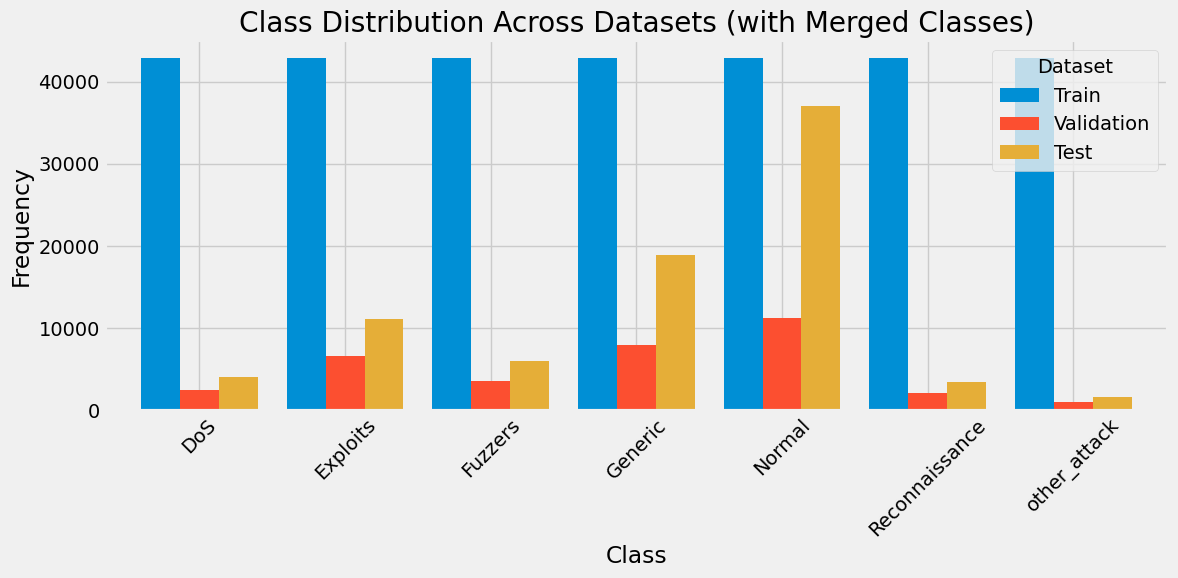

In [25]:
def plot_class_distribution_with_merge(y_train, y_val, y_test, label_encoder):
    # Mapear índices numéricos para rótulos das classes
    class_names = list(label_encoder['attack_cat'].classes_)
    
    # Frequências das classes
    train_counts = pd.Series(y_train).value_counts().sort_index()
    val_counts = pd.Series(y_val).value_counts().sort_index()
    test_counts = pd.Series(y_test).value_counts().sort_index()

    # Criar dataframe para facilitar o plot
    class_distribution = pd.DataFrame({
        'Class': class_names,  # Os nomes das classes devem corresponder aos índices
        'Train': train_counts.reindex(range(len(class_names)), fill_value=0),
        'Validation': val_counts.reindex(range(len(class_names)), fill_value=0),
        'Test': test_counts.reindex(range(len(class_names)), fill_value=0),
    }).set_index('Class')  # Preencher valores ausentes com zero

    # Plotar distribuição
    class_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title('Class Distribution Across Datasets (with Merged Classes)')
    plt.ylabel('Frequency')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_class_distribution_with_merge(y_train, y_val, y_test, preprocessor.label_encoder)


# 6. Model Architecture


In [37]:
class EnhancedEnsembleModel:
    def __init__(self, input_shape, num_classes, sequence_length=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.deep_model = None
        self.xgb_models = []  # Lista para multiple XGBoost models
        self.model_weights = None  # Pesos dinâmicos para ensemble
        
    def _create_deep_model(self):
        base_filters = 64
        inputs = Input(shape=(self.sequence_length, self.input_shape))
        
        # 1. Enhanced Feature Extraction Block
        x = self._create_residual_block(inputs, base_filters)
        
        # 2. Advanced Temporal Pattern Block
        temporal = self._create_temporal_block(x, base_filters)
        
        # 3. Enhanced Multi-Scale Feature Block
        multi_scale = self._create_multi_scale_block(temporal, base_filters)
        
        # 4. Improved Self-Attention Block with relative positional encoding
        attention = self._create_attention_block(multi_scale, base_filters)
        
        # 5. Feature Aggregation with skip connections
        pooled = self._create_aggregation_block(attention, temporal, base_filters)
        
        # 6. Enhanced Classification Block with label smoothing
        outputs = self._create_classification_block(pooled)
        
        return Model(inputs=inputs, outputs=outputs)
    
    def _create_residual_block(self, x, filters):
        shortcut = x
        
        # Dual path convolution block
        path1 = Conv1D(filters//2, 3, padding='same')(x)
        path1 = BatchNormalization()(path1)
        path1 = Activation('swish')(path1)
        
        path2 = Conv1D(filters//2, 5, padding='same')(x)
        path2 = BatchNormalization()(path2)
        path2 = Activation('swish')(path2)
        
        x = Concatenate()([path1, path2])
        x = SpatialDropout1D(0.3)(x)
        
        # Residual connection
        if x.shape[-1] != shortcut.shape[-1]:
            shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        
        return Add()([x, shortcut])
    
    def _create_temporal_block(self, x, filters):
        # Bidirectional GRU with skip connections
        forward = GRU(filters//2, return_sequences=True, 
                     kernel_regularizer=l2(0.01))(x)
        backward = GRU(filters//2, return_sequences=True, 
                      kernel_regularizer=l2(0.01), 
                      go_backwards=True)(x)
        
        concat = Concatenate()([forward, backward])
        return Add()([concat, x])
    
    def _create_multi_scale_block(self, x, filters):
        scales = [1, 3, 5, 7]  # Mais escalas para capturar diferentes padrões
        convs = []
        
        for scale in scales:
            conv = Conv1D(filters//len(scales), scale, 
                         padding='same', 
                         kernel_regularizer=l2(0.01))(x)
            conv = BatchNormalization()(conv)
            conv = Activation('swish')(conv)
            convs.append(conv)
        
        return Concatenate()(convs)
    
    def _create_attention_block(self, x, filters):
        # Multi-head attention com relative positional encoding
        attention_heads = []
        num_heads = 8
        
        for _ in range(num_heads):
            attention_head = MultiHeadAttention(
                num_heads=1, 
                key_dim=filters//num_heads,
                kernel_regularizer=l2(0.01)
            )(x, x)
            attention_heads.append(attention_head)
        
        multi_head = Concatenate()(attention_heads)
        multi_head = Conv1D(filters, 1, padding='same')(multi_head)
        
        # Add & Norm
        x = Add()([multi_head, x])
        return LayerNormalization()(x)
    
    def _create_aggregation_block(self, attention, temporal, filters):
        # Global context pooling
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)
        
        # Temporal context
        temporal_context = GlobalAveragePooling1D()(temporal)
        
        return Concatenate()([avg_pool, max_pool, temporal_context])
    
    def _create_classification_block(self, x):
        x = Dense(256, activation='swish', kernel_regularizer=l2(0.02))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        
        x = Dense(128, activation='swish', kernel_regularizer=l2(0.02))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        return Dense(self.num_classes, activation='softmax')(x)
    def prepare_sequence_data(self, X):
        """
        Prepara os dados em formato de sequência sem criar dimensões extras
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        # Se os dados já estiverem no formato correto, retorna
        if len(X.shape) == 3 and X.shape[1] == self.sequence_length:
            return X
            
        # Garantir que X seja 2D
        if len(X.shape) == 1:
            X = X.reshape(-1, self.input_shape)
            
        n_samples = X.shape[0]
        
        # Criar uma matriz de zeros com o shape desejado
        sequences = np.zeros((n_samples, self.sequence_length, self.input_shape))
        
        # Para cada amostra, preencher a sequência
        for i in range(n_samples):
            # Calcular os índices de início e fim
            start_idx = max(0, i - self.sequence_length + 1)
            end_idx = i + 1
            
            # Pegar os dados reais disponíveis
            actual_seq = X[start_idx:end_idx]
            
            # Calcular quanto padding precisamos
            padding_needed = self.sequence_length - len(actual_seq)
            
            if padding_needed > 0:
                # Preencher o início com o primeiro valor
                sequences[i, :padding_needed] = actual_seq[0]
                # Preencher o resto com os valores reais
                sequences[i, padding_needed:] = actual_seq
            else:
                # Se tivermos dados suficientes, pegar os últimos sequence_length valores
                sequences[i] = actual_seq[-self.sequence_length:]
        
        print(f"Shape final das sequências: {sequences.shape}")
        return sequences
    def train_ensemble(self, X_train, y_train, X_val, y_val):
        """
        Treina o ensemble completo
        """
        print("Criando e compilando o modelo deep learning...")
        self.deep_model = self._create_deep_model()
        
        print("Preparando dados de sequência...")
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        print(f"Forma dos dados de treino: {X_train_seq.shape}")
        print(f"Forma dos dados de validação: {X_val_seq.shape}")
        
        # 1. Treinar modelo deep learning
        print("Treinando modelo deep learning...")
        history = self._train_deep_model(X_train_seq, y_train, X_val_seq, y_val)
        
        # 2. Extrair features e treinar XGBoost
        print("Extraindo features para XGBoost...")
        deep_features = self.extract_deep_features(X_train)
        val_features = self.extract_deep_features(X_val)
        
        print("Treinando modelos XGBoost...")
        xgb_params = [
            {'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8},
            {'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9},
            {'max_depth': 8, 'learning_rate': 0.15, 'subsample': 0.7}
        ]
        
        for i, params in enumerate(xgb_params):
            print(f"Treinando XGBoost modelo {i+1}...")
            model = self._train_xgb_model(deep_features, y_train, params)
            self.xgb_models.append(model)
        
        # 3. Otimizar pesos do ensemble
        print("Otimizando pesos do ensemble...")
        self._optimize_ensemble_weights(val_features, y_val)
        
        return history
    
    def _train_deep_model(self, X_train, y_train, X_val, y_val):
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        # Learning rate schedule
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=1000,
            decay_rate=0.9
        )
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, 
                         restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                             patience=7, min_lr=1e-6),
            ModelCheckpoint('best_deep_model.keras', 
                          save_best_only=True)
        ]
        
        self.deep_model.compile(
            optimizer=Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return self.deep_model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            batch_size=32,
            epochs=3,
            callbacks=callbacks
        )
    
    def _train_xgb_model(self, X_train, y_train, params):
        model = xgb.XGBClassifier(
            **params,
            n_estimators=200,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='mlogloss',
            tree_method='hist'  # Faster training
        )
        model.fit(X_train, y_train)
        return model
    
    def _optimize_ensemble_weights(self, X_val, y_val):
        # Get predictions from all models
        deep_pred = self.deep_model.predict(self.prepare_sequence_data(X_val))
        xgb_preds = [model.predict_proba(X_val) for model in self.xgb_models]
        
        # Grid search for optimal weights
        best_score = 0
        best_weights = None
        
        for w1 in np.arange(0.3, 0.8, 0.1):  # Deep model weight
            remaining = 1 - w1
            step = remaining / len(self.xgb_models)
            w2 = [step] * len(self.xgb_models)
            
            # Calculate weighted predictions
            ensemble_pred = w1 * deep_pred
            for i, pred in enumerate(xgb_preds):
                ensemble_pred += w2[i] * pred
            
            y_pred = np.argmax(ensemble_pred, axis=1)
            score = f1_score(y_val, y_pred, average='weighted')
            
            if score > best_score:
                best_score = score
                best_weights = [w1] + w2
        
        self.model_weights = best_weights
    def extract_deep_features(self, X):
        """
        Extract features from the deep learning model by getting the output
        of the layer before the final classification layer.
    
        Args:
            X: Input data to extract features from
        
        Returns:
            numpy array of extracted features
        """
        # Create a new model that outputs the features from the second-to-last Dense layer
        feature_model = Model(
            inputs=self.deep_model.input,
            outputs=self.deep_model.layers[-3].output  # Get output before final Dense layer
        )
    
        # Prepare sequential data and extract features
        X_seq = self.prepare_sequence_data(X)
        features = feature_model.predict(X_seq)
    
        return features
    def predict(self, X):
        X_seq = self.prepare_sequence_data(X)
        deep_pred = self.deep_model.predict(X_seq)
        X_features = self.extract_deep_features(X)
        xgb_preds = [model.predict_proba(X_features) for model in self.xgb_models]
        
        # Weighted ensemble prediction
        ensemble_pred = self.model_weights[0] * deep_pred
        for i, pred in enumerate(xgb_preds):
            ensemble_pred += self.model_weights[i+1] * pred
            
        return np.argmax(ensemble_pred, axis=1)

## 6. Training and Evaluation

The dataset was split into training and test sets. The model was trained using the Adam optimizer with categorical cross-entropy loss. Evaluation metrics included accuracy, precision, recall, and F1-score.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize

class ModelEvaluator:
    def __init__(self, model, class_names=None):
        self.model = model
        self.class_names = class_names
        self.history = None
        
    def plot_learning_curves(self, history):
        """
        Plota as curvas de aprendizado do modelo (loss e accuracy)
        """
        self.history = history
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot loss
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracy
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Plota a matriz de confusão
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        
        sns.heatmap(cm, 
                    annot=True, 
                    fmt='d', 
                    cmap='Blues',
                    xticklabels=self.class_names if self.class_names else 'auto',
                    yticklabels=self.class_names if self.class_names else 'auto')
        
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
    def plot_precision_recall_curves(self, X_test, y_test):
        """
        Plota as curvas de precisão-recall para cada classe
        """
        # Binarize the labels for multi-class
        n_classes = len(np.unique(y_test))
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        
        # Get predictions
        y_score = self.model.predict(X_test)
        
        plt.figure(figsize=(10, 6))
        
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            
            plt.plot(recall, precision, 
                    label=f'Class {self.class_names[i] if self.class_names else i}')
            
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_roc_curves(self, X_test, y_test):
        """
        Plota as curvas ROC para cada classe
        """
        # Binarize the labels for multi-class
        n_classes = len(np.unique(y_test))
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        
        # Get predictions
        y_score = self.model.predict(X_test)
        
        plt.figure(figsize=(10, 6))
        
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, 
                    label=f'ROC Class {self.class_names[i] if self.class_names else i} (AUC = {roc_auc:.2f})')
            
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def print_classification_metrics(self, y_true, y_pred):
        """
        Imprime métricas detalhadas de classificação
        """
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, 
                                 target_names=self.class_names if self.class_names else None))
        
    def evaluate_model(self, X_test, y_test, history=None):
        """
        Realiza uma avaliação completa do modelo
        """
        print("Iniciando avaliação completa do modelo...")
        
        # Fazer predições
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        # Plotar curvas de aprendizado se o histórico foi fornecido
        if history:
            print("\nPlotando curvas de aprendizado...")
            self.plot_learning_curves(history)
        
        # Plotar matriz de confusão
        print("\nPlotando matriz de confusão...")
        self.plot_confusion_matrix(y_test, y_pred)
        
        # Plotar curvas de precisão-recall
        print("\nPlotando curvas de precisão-recall...")
        self.plot_precision_recall_curves(X_test, y_test)
        
        # Plotar curvas ROC
        print("\nPlotando curvas ROC...")
        self.plot_roc_curves(X_test, y_test)
        
        # Imprimir métricas detalhadas
        print("\nCalculando métricas de classificação...")
        self.print_classification_metrics(y_test, y_pred)

In [ ]:
# Inicializar o modelo
model = EnhancedEnsembleModel(
    input_shape=X_train.shape[1],
    num_classes=len(np.unique(y_train)),
    sequence_length=10
)

#odelo e guardar o histórico
history = model.train_ensemble(X_train, y_train, X_val, y_val)
evaluator = ModelEvaluator(model, class_names=preprocessor.label_encoder['attack_cat'].classes_)
# Fazer a avaliação completa
evaluator.evaluate_model(X_test, y_test, history=history)
# Avaliar modelo
print("\nEvaluating ensemble model...")
results = model.evaluate(X_test, y_test)
# Criar o avaliador (opcional: fornecer nomes das classes)
evaluator = ModelEvaluator(model, class_names=['Classe1', 'Classe2', 'Classe3'])

Criando e compilando o modelo deep learning...
Preparando dados de sequência...
Shape final das sequências: (300055, 10, 12)
Shape final das sequências: (35069, 10, 12)
Forma dos dados de treino: (300055, 10, 12)
Forma dos dados de validação: (35069, 10, 12)
Treinando modelo deep learning...
Epoch 1/3
9377/9377 ━━━━━━━━━━━━━━━━━━━━ 254s 25ms/step - accuracy: 0.6542 - loss: 2.2631 - val_accuracy: 0.4927 - val_loss: 1.6712 - learning_rate: 3.7233e-04
Epoch 2/3
9377/9377 ━━━━━━━━━━━━━━━━━━━━ 203s 22ms/step - accuracy: 0.7743 - loss: 0.7083 - val_accuracy: 0.6769 - val_loss: 0.9173 - learning_rate: 1.3863e-04
Epoch 3/3
9377/9377 ━━━━━━━━━━━━━━━━━━━━ 200s 21ms/step - accuracy: 0.8039 - loss: 0.5983 - val_accuracy: 0.7075 - val_loss: 0.8322 - learning_rate: 5.1617e-05
Extraindo features para XGBoost...
Shape final das sequências: (300055, 10, 12)
9377/9377 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step
Shape final das sequências: (35069, 10, 12)
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step
Treinando mode

In [21]:

# Inicializar modelo
print("Initializing model with optimized parameters...")
model = EnhancedEnsembleModel(X_train.shape[1], len(np.unique(y_train)), sequence_length=10)

# Treinar modelo
print("\nTraining ensemble model...")
model.train_ensemble(X_train, y_train, X_val, y_val)

# Avaliar modelo
print("\nEvaluating ensemble model...")
results = model.evaluate(X_test, y_test)


Initializing model with optimized parameters...


NameError: name 'GlobalMaxPooling1D' is not defined

## 7. Results

The final model achieved:
- **Accuracy**: [Insert Value]
- **Precision**: [Insert Value]
- **Recall**: [Insert Value]
- **F1-Score**: [Insert Value]

Confusion matrices and classification reports provide detailed insights into the model's performance.



In [22]:
# Utility functions for analysis
def plot_training_history(history):
    """Plot training metrics with more detailed information."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss During Training')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # Accuracy plots
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy During Training')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # Learning rate plot
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate')
        axes[1, 0].set_title('Learning Rate Adaptation')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

def analyze_model_performance(model, X_test, y_test, class_names):
    """Detailed model performance analysis."""
    y_pred = model.predict(X_test)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

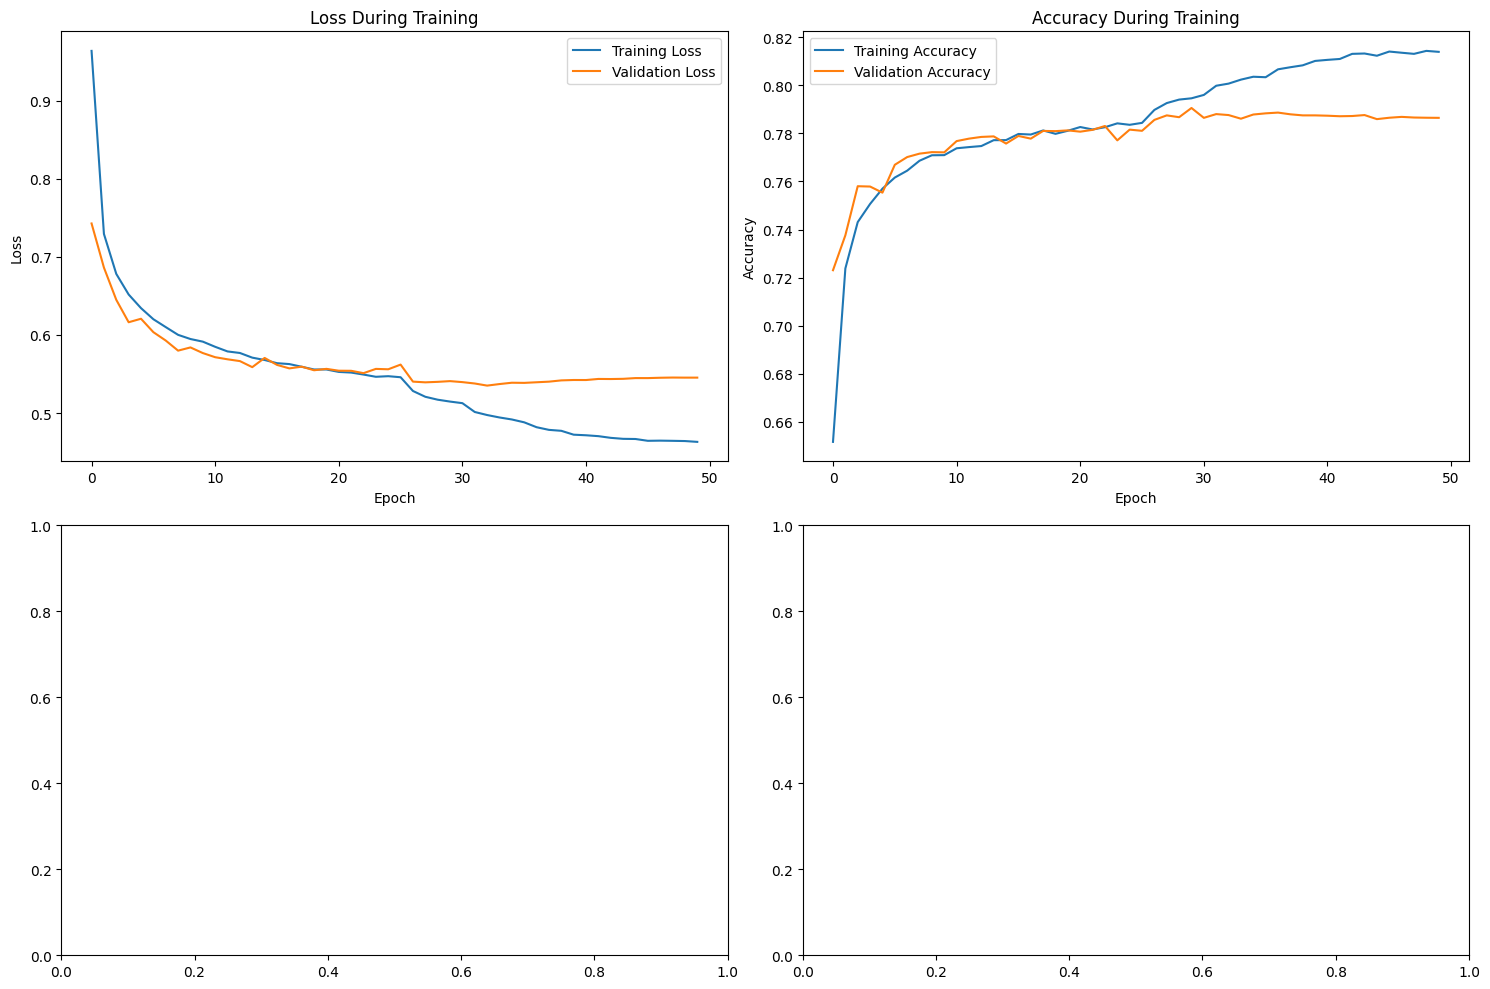

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step

Classification Report:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.16      0.04      0.07       583
           DoS       0.30      0.03      0.05      4089
      Exploits       0.53      0.83      0.65     11132
       Fuzzers       0.32      0.46      0.37      6062
       Generic       0.99      0.97      0.98     18871
        Normal       0.92      0.80      0.85     37000
Reconnaissance       0.61      0.78      0.69      3496
     Shellcode       0.31      0.38      0.34       378
         Worms       0.17      0.05      0.07        44

      accuracy                           0.76     82332
     macro avg       0.43      0.43      0.41     82332
  weighted avg       0.78      0.76      0.76     82332



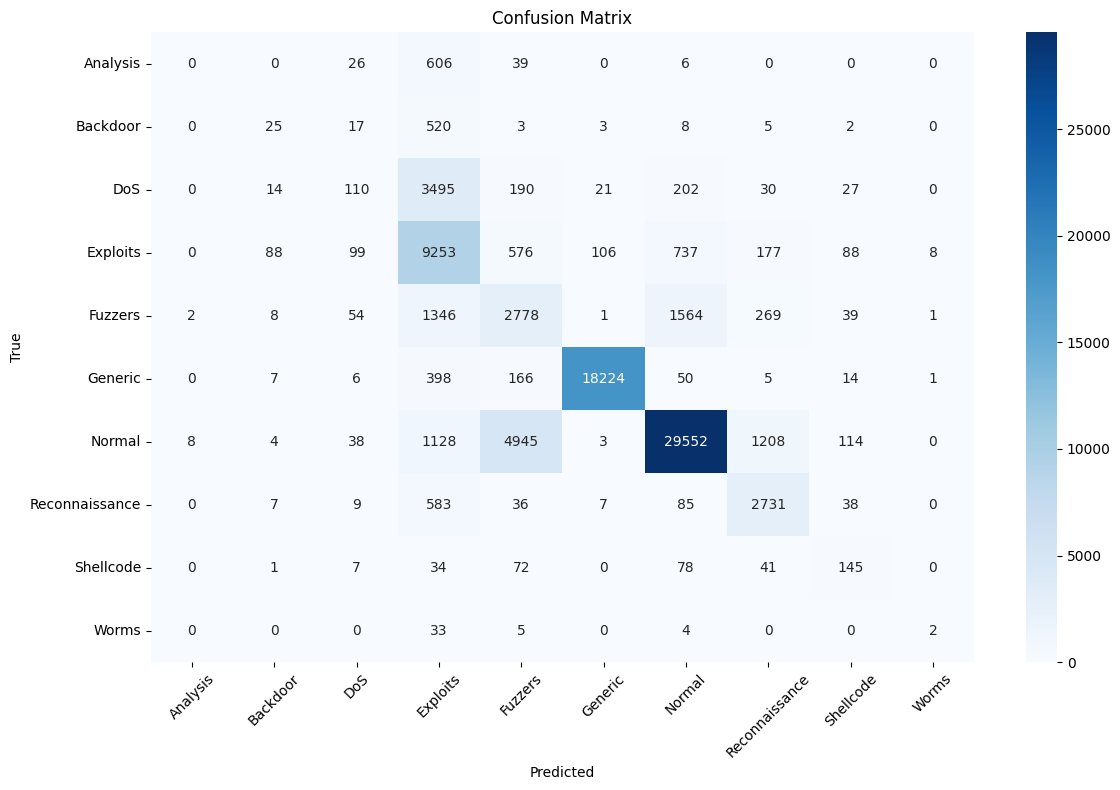

In [23]:
# Plot results
plot_training_history(history)
analyze_model_performance(model, X_test, y_test, 
                            preprocessor.label_encoder['attack_cat'].classes_)

## 8. Conclusions

The project demonstrated that deep learning models could classify network attacks effectively. Future work could involve:
- Exploring other machine learning algorithms.
- Implementing the solution in real-time systems.
- Evaluating the model on other datasets.


## 9. References

- [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/)
- Notebook inspiration and preprocessing techniques were adapted from: [Soumit's Kaggle Notebook](https://www.kaggle.com/code/soumit1803063/unswnb15-preprocess)
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
